# LSTM Cell Size Analysis

This notebook analyzes the effect of different LSTM cell sizes on model performance.

In [9]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import classification_report, f1_score
import matplotlib.pyplot as plt
import json
import os
import sys

current_dir = os.path.dirname(os.path.abspath('__file__'))
parent_dir = os.path.dirname(os.path.dirname(current_dir))
if parent_dir not in sys.path:
    sys.path.insert(0, parent_dir)

from lstm.text_preprocessor import TextPreprocessor
from lstm.lstm_model import LSTMModel

np.random.seed(42)
tf.random.set_seed(42)

os.makedirs('../../models', exist_ok=True)

## Load and Preprocess Data from CSV

In [10]:
# Load data from CSV files
train_df = pd.read_csv('../../../data/nusax/train.csv')
valid_df = pd.read_csv('../../../data/nusax/valid.csv')
test_df = pd.read_csv('../../../data/nusax/test.csv')

label_mapping = {
    'negative': 0,
    'neutral': 1,
    'positive': 2
}

train_texts = train_df['text'].values
val_texts = valid_df['text'].values
test_texts = test_df['text'].values

if train_df['label'].dtype == 'object':
    train_labels = train_df['label'].map(label_mapping).values
    val_labels = valid_df['label'].map(label_mapping).values
    test_labels = test_df['label'].map(label_mapping).values
else:
    train_labels = train_df['label'].values
    val_labels = valid_df['label'].values
    test_labels = test_df['label'].values

# Configuration
MAX_VOCAB_SIZE = 10000
MAX_SEQUENCE_LENGTH = 100

preprocessor = TextPreprocessor(
    max_tokens=MAX_VOCAB_SIZE,
    output_sequence_length=MAX_SEQUENCE_LENGTH,
    standardize='lower_and_strip_punctuation'
)

print("Fitting the text preprocessor on training data...")
preprocessor.fit(train_texts)

vocab = preprocessor.get_vocabulary()
vocab_size = preprocessor.get_vocab_size()

train_sequences = preprocessor.preprocess(train_texts)
val_sequences = preprocessor.preprocess(val_texts)
test_sequences = preprocessor.preprocess(test_texts)

num_classes = len(np.unique(train_labels))
max_seq_length = MAX_SEQUENCE_LENGTH

print(f"Data loaded and preprocessed successfully!")
print(f"Training data shape: {train_sequences.shape}")
print(f"Label distribution in training data: {np.bincount(train_labels)}")
print(f"Vocabulary size: {vocab_size}")

Fitting the text preprocessor on training data...
Data loaded and preprocessed successfully!
Training data shape: (500, 100)
Label distribution in training data: [192 119 189]
Vocabulary size: 2836


## Model Building Functions

### Model Hyperparameters (Default Values)

- **LSTM Units (`units`)**: Number of LSTM cells in the main recurrent layer. Default values used in experiments: `32`, `64`, and `128`.
- **Embedding Dimension (`embedding_dim`)**: Size of the word embedding vectors. Default: `100`.
- **Direction (`direction`)**: LSTM directionality. Default: `unidirectional`
- **Dropout Rates**: 
    - After LSTM layer: `0.3`
    - After first Dense layer: `0.5`
- **Dense Layer Size**: First dense layer after LSTM uses `32` units with ReLU activation.
- **Output Layer**: Dense layer with `num_classes` units (softmax activation).
- **Optimizer**: Adam with learning rate `0.001`.
- **Loss Function**: Sparse categorical cross-entropy.
- **Batch Size**: `32`
- **Epochs**: `10`

In [11]:
def create_custom_lstm_model_with_units(lstm_units, embedding_dim=100):
   
    model = LSTMModel(preprocessor=preprocessor)
    
    model.set_label_mapping(label_mapping)
    
    model.add_embedding(vocab_size, embedding_dim, max_seq_length)
    model.add_lstm(lstm_units, return_sequences=False)
    model.add_dropout(0.3)
    model.add_dense(32, activation='relu')
    model.add_dropout(0.5)
    model.add_dense(num_classes, activation='softmax')
    
    return model

def create_keras_lstm_model_with_units(lstm_units, embedding_dim=100):
   
    model = Sequential()
    
    model.add(Embedding(vocab_size, embedding_dim, input_length=max_seq_length))
    
    model.add(LSTM(lstm_units))
    model.add(Dropout(0.3))
    
    model.add(Dense(32, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(num_classes, activation='softmax'))
    
    return model

def compile_and_train_model(model, model_name):
  
    print(f"\nTraining {model_name}...")
    
    if isinstance(model, LSTMModel):
        lstm_units = None
        for layer in model.layers:
            if hasattr(layer, 'units'):
                lstm_units = layer.units
                break
                
        if lstm_units is None:
            raise ValueError("Could not determine LSTM units in the custom model")
        
        keras_model = create_keras_lstm_model_with_units(lstm_units=lstm_units)
        keras_model.build(input_shape=(None, max_seq_length)) 
        keras_model.compile(
            optimizer=Adam(learning_rate=0.001),
            loss='sparse_categorical_crossentropy',
            metrics=['accuracy']
        )
        
        print(f"Training Keras model (will transfer weights to custom model)")
        print(f"Total parameters: {keras_model.count_params():,}")
        
        history = keras_model.fit(
            train_sequences, train_labels,
            batch_size=32,
            epochs=10,
            validation_data=(val_sequences, val_labels),
            verbose=1
        )
        
        print("Transferring weights to custom LSTM model...")
        model.load_weights_from_keras(keras_model)
        print("Weights transferred successfully")
        
    else:
        model.build(input_shape=(None, max_seq_length)) 
        model.compile(
            optimizer=Adam(learning_rate=0.001),
            loss='sparse_categorical_crossentropy',
            metrics=['accuracy']
        )
        
        print(f"Total parameters: {model.count_params():,}")
        history = model.fit(
            train_sequences, train_labels,
            batch_size=32,
            epochs=10,
            validation_data=(val_sequences, val_labels),
            verbose=1
        )
    
    return history

def evaluate_model(model, model_name, history):
   
    print(f"Evaluating {model_name}...")
    
    y_pred = model.predict(test_sequences)
    y_pred_classes = np.argmax(y_pred, axis=1)
    
    f1 = f1_score(test_labels, y_pred_classes, average='macro')
    
    print(f"\n{model_name} Results:")
    print(classification_report(test_labels, y_pred_classes))
    print(f"Macro F1-score: {f1:.4f}")
    
    return f1, history

## Experiment 1: 32 LSTM Units

In [12]:
model_32_units = create_custom_lstm_model_with_units(lstm_units=32)
history_32_units = compile_and_train_model(model_32_units, "32 LSTM Units")
f1_32_units, _ = evaluate_model(model_32_units, "32 LSTM Units", history_32_units)


Training 32 LSTM Units...
Training Keras model (will transfer weights to custom model)
Total parameters: 301,779
Epoch 1/10


c:\Users\Adittya Mininda\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 53ms/step - accuracy: 0.4065 - loss: 1.0872 - val_accuracy: 0.3800 - val_loss: 1.0781
Epoch 2/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.4136 - loss: 1.0748 - val_accuracy: 0.3800 - val_loss: 1.0786
Epoch 3/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.3924 - loss: 1.0779 - val_accuracy: 0.3800 - val_loss: 1.0802
Epoch 4/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.3931 - loss: 1.0721 - val_accuracy: 0.3800 - val_loss: 1.0786
Epoch 5/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.3878 - loss: 1.0761 - val_accuracy: 0.3800 - val_loss: 1.0788
Epoch 6/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.3928 - loss: 1.0868 - val_accuracy: 0.3800 - val_loss: 1.0787
Epoch 7/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.3644 - loss: 1.0765 - val_accuracy: 0.3800 - val_loss: 1.0789
Epoch 8/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.4070 - loss: 1.0661 - val_accuracy: 0.3800 - val_loss: 1.

c:\Users\Adittya Mininda\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Adittya Mininda\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Adittya Mininda\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this beh

## Experiment 2: 64 LSTM Units

In [13]:
model_64_units = create_custom_lstm_model_with_units(lstm_units=64)
history_64_units = compile_and_train_model(model_64_units, "64 LSTM Units")
f1_64_units, _ = evaluate_model(model_64_units, "64 LSTM Units", history_64_units)


Training 64 LSTM Units...
Training Keras model (will transfer weights to custom model)
Total parameters: 328,019
Epoch 1/10


c:\Users\Adittya Mininda\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 46ms/step - accuracy: 0.3145 - loss: 1.0997 - val_accuracy: 0.3800 - val_loss: 1.0844
Epoch 2/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - accuracy: 0.3548 - loss: 1.0850 - val_accuracy: 0.3800 - val_loss: 1.0796
Epoch 3/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.4262 - loss: 1.0718 - val_accuracy: 0.3800 - val_loss: 1.0788
Epoch 4/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - accuracy: 0.4159 - loss: 1.0793 - val_accuracy: 0.3800 - val_loss: 1.0784
Epoch 5/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - accuracy: 0.4094 - loss: 1.0720 - val_accuracy: 0.3800 - val_loss: 1.0782
Epoch 6/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - accuracy: 0.3838 - loss: 1.0782 - val_accuracy: 0.3800 - val_loss: 1.0806
Epoch 7/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - accuracy: 0.3910 - loss: 1.0727 - val_accuracy: 0.3800 - val_loss: 1.0791
Epoch 8/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - accuracy: 0.3693 - loss: 1.0750 - val_accuracy: 0.3800 - val_loss: 1.

c:\Users\Adittya Mininda\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Adittya Mininda\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Adittya Mininda\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this beh

## Experiment 3: 128 LSTM Units

In [14]:
model_128_units = create_custom_lstm_model_with_units(lstm_units=128)
history_128_units = compile_and_train_model(model_128_units, "128 LSTM Units")
f1_128_units, _ = evaluate_model(model_128_units, "128 LSTM Units", history_128_units)


Training 128 LSTM Units...
Training Keras model (will transfer weights to custom model)
Total parameters: 405,075
Epoch 1/10


c:\Users\Adittya Mininda\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


16/16 ━━━━━━━━━━━━━━━━━━━━ 4s 88ms/step - accuracy: 0.3649 - loss: 1.0876 - val_accuracy: 0.3800 - val_loss: 1.0802
Epoch 2/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 61ms/step - accuracy: 0.4289 - loss: 1.0751 - val_accuracy: 0.3800 - val_loss: 1.0789
Epoch 3/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 61ms/step - accuracy: 0.3904 - loss: 1.0797 - val_accuracy: 0.3800 - val_loss: 1.0789
Epoch 4/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 58ms/step - accuracy: 0.3809 - loss: 1.0682 - val_accuracy: 0.3800 - val_loss: 1.0780
Epoch 5/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 62ms/step - accuracy: 0.3885 - loss: 1.0649 - val_accuracy: 0.3800 - val_loss: 1.0780
Epoch 6/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 62ms/step - accuracy: 0.4079 - loss: 1.0724 - val_accuracy: 0.3800 - val_loss: 1.0782
Epoch 7/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 62ms/step - accuracy: 0.3711 - loss: 1.0725 - val_accuracy: 0.3800 - val_loss: 1.0783
Epoch 8/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 68ms/step - accuracy: 0.3591 - loss: 1.0761 - val_accuracy: 0.3800 - val_loss: 1.

c:\Users\Adittya Mininda\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Adittya Mininda\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Adittya Mininda\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this beh

## Results Comparison

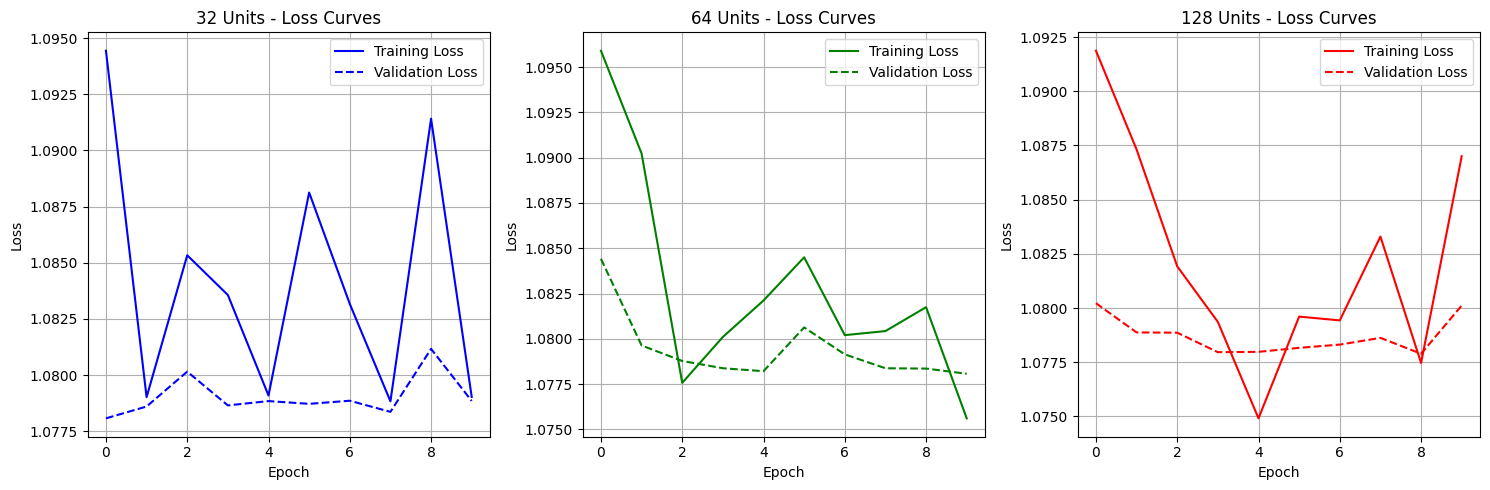

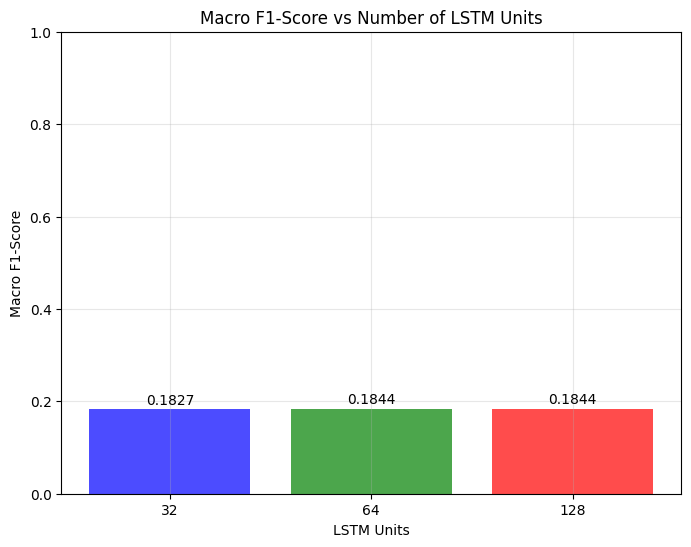

c:\Users\Adittya Mininda\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


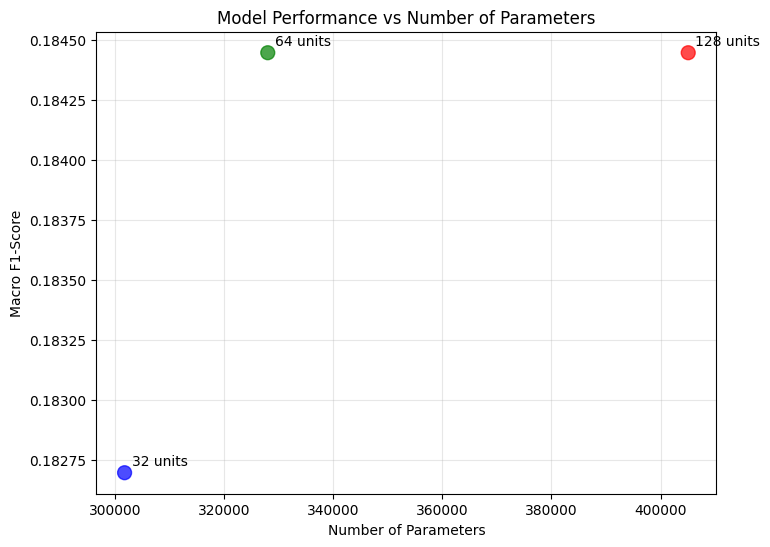


=== LSTM Units Analysis Results ===
32 LSTM Units: F1-Score = 0.1827, Parameters = 301,779
64 LSTM Units: F1-Score = 0.1844, Parameters = 328,019
128 LSTM Units: F1-Score = 0.1844, Parameters = 405,075


In [15]:
# Plot training/validation loss curves
plt.figure(figsize=(15, 5))

histories = [history_32_units, history_64_units, history_128_units]
names = ['32 Units', '64 Units', '128 Units']
colors = ['blue', 'green', 'red']

for i, (history, name, color) in enumerate(zip(histories, names, colors)):
    plt.subplot(1, 3, i+1)
    plt.plot(history.history['loss'], label='Training Loss', color=color)
    plt.plot(history.history['val_loss'], label='Validation Loss', color=color, linestyle='--')
    plt.title(f'{name} - Loss Curves')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)

plt.tight_layout()
plt.show()

# Compare F1 scores
f1_scores = [f1_32_units, f1_64_units, f1_128_units]
unit_counts = [32, 64, 128]

plt.figure(figsize=(8, 6))
plt.bar(range(len(unit_counts)), f1_scores, color=['blue', 'green', 'red'], alpha=0.7)
plt.title('Macro F1-Score vs Number of LSTM Units')
plt.xlabel('LSTM Units')
plt.ylabel('Macro F1-Score')
plt.xticks(range(len(unit_counts)), unit_counts)
plt.ylim(0, 1)
for i, score in enumerate(f1_scores):
    plt.text(i, score + 0.01, f'{score:.4f}', ha='center')
plt.grid(True, alpha=0.3)
plt.show()

model_params = []
for units in unit_counts:
    keras_model = create_keras_lstm_model_with_units(lstm_units=units)
    keras_model.build(input_shape=(None, max_seq_length))  
    model_params.append(keras_model.count_params())

plt.figure(figsize=(8, 6))
plt.scatter(model_params, f1_scores, s=100, c=['blue', 'green', 'red'], alpha=0.7)
for i, (params, f1, units) in enumerate(zip(model_params, f1_scores, unit_counts)):
    plt.annotate(f'{units} units', (params, f1), xytext=(5, 5), textcoords='offset points')
plt.title('Model Performance vs Number of Parameters')
plt.xlabel('Number of Parameters')
plt.ylabel('Macro F1-Score')
plt.grid(True, alpha=0.3)
plt.show()

print("\n=== LSTM Units Analysis Results ===")
for units, f1, params in zip(unit_counts, f1_scores, model_params):
    print(f"{units} LSTM Units: F1-Score = {f1:.4f}, Parameters = {params:,}")

## Save Best Model and Testing

In [16]:
best_idx = np.argmax(f1_scores)
best_model = [model_32_units, model_64_units, model_128_units][best_idx]
best_units = unit_counts[best_idx]
best_f1 = f1_scores[best_idx]

print(f"Best model: {best_units} LSTM units with F1-Score: {best_f1:.4f}")

model_path = '../../models/best_lstm_units_custom'
best_model.save(model_path, save_preprocessor=True)
print(f"Best model saved to {model_path}")

keras_model = create_keras_lstm_model_with_units(lstm_units=best_units)
keras_model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)
keras_model.fit(
    train_sequences, train_labels,
    batch_size=32,
    epochs=1, 
    verbose=0
)
keras_model.save('../../models/best_lstm_units_model.keras')
print("Keras model saved as 'best_lstm_units_model.keras' for compatibility")

sample_texts = [
    "Saya sangat suka layanan ini, sangat memuaskan!",  
    "Pesanan saya belum datang padahal sudah lewat tenggat waktu" 
]

direct_predictions = best_model.predict_labels(sample_texts)

print("\nDirect text prediction example:")
for text, pred_label in zip(sample_texts, direct_predictions):
    print(f"Text: {text}")
    print(f"Predicted sentiment: {pred_label}\n")

Best model: 64 LSTM units with F1-Score: 0.1844
Best model saved to ../../models/best_lstm_units_custom
Keras model saved as 'best_lstm_units_model.keras' for compatibility

Direct text prediction example:
Text: Saya sangat suka layanan ini, sangat memuaskan!
Predicted sentiment: negative

Text: Pesanan saya belum datang padahal sudah lewat tenggat waktu
Predicted sentiment: negative

